# Iowa Prison Recidivism Analysis

Author: Robert Harrow

## Overview

Stakeholder: Iowa Department of Corrections
Business Questions:
1. What features can help predict recidivism?
2. What can the DoC do to reduce recidivism?

## Data Understanding & Preperation

### Importing Dataset

Dataset located at: https://mydata.iowa.gov/Correctional-System/3-Year-Recidivism-for-Offenders-Released-from-Pris/mw8r-vqy4

**Load Dependencies**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score

### Data Dictionary

| Column Name                | Description                                                                                                                                                                                                          |
|:---------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Fiscal Year Released       | Fiscal year (year ending June 30) for which the offender was released from prison.                                                                                                                                   |
| Recidivism Reporting Year  | Fiscal year (year ending June 30) that marks the end of the 3-year tracking period. For example, offenders exited prison in FY 2012 are found in recidivism reporting year FY 2015.                                  |
| Main Supervising District  | The Judicial District supervising the offender for the longest time during the tracking period.                                                                                                                      |
| Release Type               | Reasoning for Offender's release from prison.                                                                                                                                                                        |
| Race - Ethnicity           | Offender's Race and Ethnicity                                                                                                                                                                                        |
| Age At Release             | Offender's age group at release from prison.                                                                                                                                                                         |
| Sex                        | Gender of our offender                                                                                                                                                                                               |
| Offense Classification     | Maximum penalties: A Felony = Life; B Felony = 25 or 50 years; C Felony = 10 years; D Felony = 5 years; Aggravated Misdemeanor = 2 years; Serious Misdemeanor = 1 year; Simple Misdemeanor = 30 days                 |
| Offense Type               | General category for the most serious offense for which the offender was placed in prison.                                                                                                                           |
| Offense Subtype            | Further classification of the most serious offense for which the offender was placed in prison.                                                                                                                      |
| Return to Prison           | No = Did not return to prison within the three year tracking period; Yes = Admitted to prison for any reason within the three year tracking period                                                                   |
| Days to Return             | Number of days it took before the offender returned to prison.                                                                                                                                                       |
| Recidivism Type            | Indicates the reason for return to prison.                                                                                                                                                                           |
| New Offense Classification | New conviction maximum penalties: A Felony = Life; B Felony = 25 or 50 years; C Felony = 10 years; D Felony = 5 years; Aggravated Misdemeanor = 2 years; Serious Misdemeanor = 1 year; Simple Misdemeanor = 30 days  |
| New Offense Type           | General category for the new conviction while the offender is out of prison.                                                                                                                                         |
| New Offense Sub Type       | Further classification of the new conviction.                                                                                                                                                                        |
| Target Population          | The Department of Corrections has undertaken specific strategies to reduce recidivism rates for prisoners who are on parole.                                                                                         |


In [2]:
prisoner_df = pd.read_csv('data/recidivism.csv')

In [3]:
# Preview first 5 rows
prisoner_df.head()

,Fiscal Year Released,Recidivism Reporting Year,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Offense Subtype,Return to Prison,Days to Return,Recidivism Type,New Offense Classification,New Offense Type,New Offense Sub Type,Target Population
0,2010,2013,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,433.0,New,C Felony,Drug,Trafficking,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,453.0,Tech,NaN,NaN,NaN,No
2,2010,2013,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,832.0,Tech,NaN,NaN,NaN,Yes
3,2010,2013,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,NaN,No Recidivism,NaN,NaN,NaN,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,116.0,Tech,NaN,NaN,NaN,No


In [4]:
# Get overview of the data
prisoner_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020 entries, 0 to 26019
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Fiscal Year Released        26020 non-null  int64  
 1   Recidivism Reporting Year   26020 non-null  int64  
 2   Main Supervising District   16439 non-null  object 
 3   Release Type                24258 non-null  object 
 4   Race - Ethnicity            25990 non-null  object 
 5   Age At Release              26017 non-null  object 
 6   Sex                         26017 non-null  object 
 7   Offense Classification      26020 non-null  object 
 8   Offense Type                26020 non-null  object 
 9   Offense Subtype             26020 non-null  object 
 10  Return to Prison            26020 non-null  object 
 11  Days to Return              8681 non-null   float64
 12  Recidivism Type             26020 non-null  object 
 13  New Offense Classification  671

In [5]:
# Explore distribution of target

prisoner_df['Return to Prison'].value_counts()

No     17339
Yes     8681
Name: Return to Prison, dtype: int64

In [6]:
prisoner_df['Recidivism Type'].value_counts()

No Recidivism    17339
New               5516
Tech              3165
Name: Recidivism Type, dtype: int64

In [7]:
# Exploring proportion of missing data
prisoner_df.isna().mean()

Fiscal Year Released          0.000000
Recidivism Reporting Year     0.000000
Main Supervising District     0.368217
Release Type                  0.067717
Race - Ethnicity              0.001153
Age At Release                0.000115
Sex                           0.000115
Offense Classification        0.000000
Offense Type                  0.000000
Offense Subtype               0.000000
Return to Prison              0.000000
Days to Return                0.666372
Recidivism Type               0.000000
New Offense Classification    0.741814
New Offense Type              0.741814
New Offense Sub Type          0.742544
Target Population             0.000000
dtype: float64

### Basic Data Cleaning

Data is missing for the following columns:
* **Main Supervising District.** Based on an email I received from the Iowa Department of Corrections <em>"When a Main Supervising District is blank, this means they discharged straight from prison and were not supervised by Community Based Corrections."</em>
* **Release Type/Race - Ethnicity/Age At Release/Sex.** Just 0.01% - 6% of data is missing here. I will likely just drop these records.
* **Days to Return/New Offense Classification/New Offense Type/New Offense Sub Type.** It makes sense for this data to be missing since we have records of people who never returned to prison. Also, we don't need these columns for modeling.

In [8]:
# Replacing Main Supervising District NaN with 'None'
prisoner_df['Main Supervising District'] = prisoner_df['Main Supervising District'].fillna('None')

In [9]:
# Dealing with records with small amounts of missing values
prisoner_df.dropna(subset=['Release Type', 'Race - Ethnicity','Age At Release ','Sex'], inplace=True)

In [10]:
# Dropping columns not needed for modeling
cols_to_drop = ['Days to Return',
                'Recidivism Type',
                'New Offense Classification',
                'New Offense Type',
                'New Offense Sub Type']

In [11]:
prisoner_df_relevant = prisoner_df.drop(cols_to_drop, axis=1)

In [12]:
# Lastly, since we are dealing with data for just a few years, we'll treat it as a string/category rather than a continuous int

prisoner_df_relevant["Fiscal Year Released"]=prisoner_df_relevant["Fiscal Year Released"].values.astype(str)
prisoner_df_relevant["Recidivism Reporting Year"]=prisoner_df_relevant["Recidivism Reporting Year"].values.astype(str)

### Split data for cleaning & training

In [13]:
X = prisoner_df_relevant.drop(['Return to Prison'], axis=1)
y = prisoner_df_relevant['Return to Prison']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [14]:
# # Instantiate a OneHotEncoder
# ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")

# # Fit the encoder on fireplace_qu_train
# ohe.fit(X_train)

# # Transform fireplace_qu_train using the encoder and
# X_train_ohe = ohe.transform(X_train)

# # Make the transformed data into a dataframe
# X_train_ohe = pd.DataFrame(
#     # Pass in NumPy array
#     X_train_ohe,
#     # Set the column names to the categories found by OHE
#     columns=ohe.get_feature_names(list(X_train.columns)),
#     # Set the index to match X_train's index
#     index=X_train.index
# )

In [15]:
# We create a ohe transform pipeline for ease of use
cols = list(X_train.columns)
ohe_trans = ColumnTransformer(transformers=
                                  [('ohe', OneHotEncoder(drop='first', sparse=False), cols)],
                                 remainder='passthrough')

In [16]:
X_train_ohe = ohe_trans.fit_transform(X_train)

### Model Iterations

In [17]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    # we pass in pipe to cross validate along with a feature list.
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Macro Precision:', results['train_precision_macro'].mean())
    print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
    print('##############')
    print('Training Macro Recall:', results['train_recall_macro'].mean())
    print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
    print('##############')
    print('Training Macro F1:', results['train_f1_macro'].mean())
    print('Cross_Val Macro F1:', results['test_f1_macro'].mean())

### Dummy classifier

In [18]:
dummy_pipe = Pipeline(steps=[
    ('dc', DummyClassifier(strategy='most_frequent'))
])

In [19]:
dummy_pipe.fit(X_train_ohe, y_train)

Pipeline(steps=[('dc', DummyClassifier(strategy='most_frequent'))])

In [20]:
print_cv_scores(dummy_pipe, X_train_ohe, y_train)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.65611669 0.65611669 0.65611669 0.65607155 0.65607155]
Training Accuracy 0.6560986357079559
##############
[0.65602642 0.65602642 0.65602642 0.65620699 0.65620699]
Cross_Val Accuracy 0.6560986468895396
##############
Training Macro Precision: 0.32804931785397795
Cross_Val Macro Precision: 0.3280493234447698
##############
Training Macro Recall: 0.5
Cross_Val Macro Recall: 0.5
##############
Training Macro F1: 0.3961712312196762
Cross_Val Macro F1: 0.39617123368137236


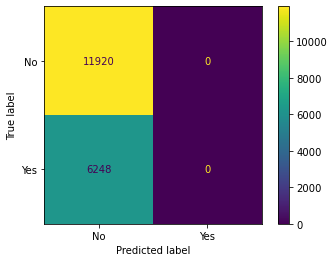

In [21]:
plot_confusion_matrix(dummy_pipe, X_train_ohe, y_train)

### Logistic Regression classifier

[0.67228567 0.671116   0.67070318 0.67320261 0.67134503]
Training Accuracy 0.6717305002388383
##############
[0.66978536 0.66978536 0.66373143 0.66363887 0.66996972]
Cross_Val Accuracy 0.6673821468678011
##############
Training Macro Precision: 0.6234669429257571
Cross_Val Macro Precision: 0.6142851312736803
##############
Training Macro Recall: 0.5647954119032742
Cross_Val Macro Recall: 0.5601204174077516
##############
Training Macro F1: 0.5507695051406809
Cross_Val Macro F1: 0.5450556326806195


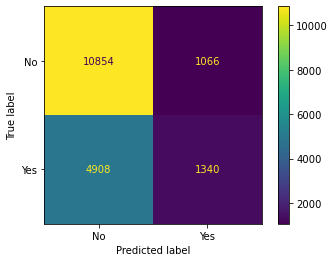

In [22]:
lr1_pipe = Pipeline(steps=[
    ('lr', LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear'))
])

lr1_pipe.fit(X_train_ohe, y_train)

print_cv_scores(lr1_pipe, X_train_ohe, y_train)
plot_confusion_matrix(lr1_pipe, X_train_ohe, y_train)

### KNN classifier

[0.73930095 0.74122747 0.74514931 0.73931889 0.74131407]
Training Accuracy 0.7412621352283619
##############
[0.62768299 0.62080352 0.61667584 0.62703    0.62840628]
Cross_Val Accuracy 0.6241197268177523
##############
Training Macro Precision: 0.714583325955613
Cross_Val Macro Precision: 0.5679898851145236
##############
Training Macro Recall: 0.6891161763961745
Cross_Val Macro Recall: 0.5603169050676783
##############
Training Macro F1: 0.6970042179013696
Cross_Val Macro F1: 0.5609290242532634


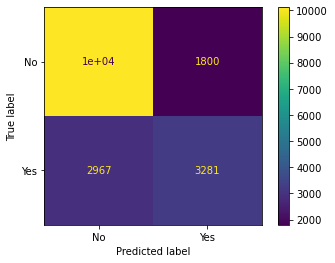

In [23]:
knn1_pipe = Pipeline(steps=[
    ('lr', KNeighborsClassifier())
])

knn1_pipe.fit(X_train_ohe, y_train)

print_cv_scores(knn1_pipe, X_train_ohe, y_train)
plot_confusion_matrix(knn1_pipe, X_train_ohe, y_train)

### Decision Tree classifier

[0.86596945 0.865075   0.8667951  0.86439628 0.86370829]
Training Accuracy 0.8651888247615913
##############
[0.6119978  0.60539351 0.62410567 0.62730526 0.61849711]
Cross_Val Accuracy 0.6174598680444243
##############
Training Macro Precision: 0.8798217728339466
Cross_Val Macro Precision: 0.5585455715505125
##############
Training Macro Recall: 0.8199431090963515
Cross_Val Macro Recall: 0.5513572350497848
##############
Training Macro F1: 0.8393680619078022
Cross_Val Macro F1: 0.5513224408888812


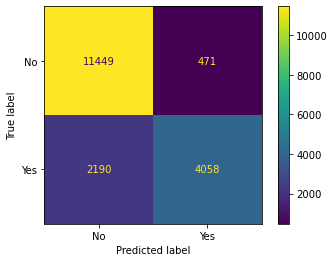

In [24]:
dt1_pipe = Pipeline(steps=[
    ('dt', DecisionTreeClassifier(criterion='entropy'))
])

dt1_pipe.fit(X_train_ohe, y_train)

print_cv_scores(dt1_pipe, X_train_ohe, y_train)
plot_confusion_matrix(dt1_pipe, X_train_ohe, y_train)

### Random Forest classifier

In [ ]:
rf_pipe = Pipeline([('RF', RandomForestClassifier(random_state=123))])

# Define the grid
grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [2, 5, 10], 
         'RF__min_samples_leaf': [1, 3, 5]}]

gridsearch = GridSearchCV(estimator=scaled_pipeline_2, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=5)

# Fit the training data
gridsearch.fit(X_train_ohe, y_train)

# Print the accuracy on test set
gridsearch.score(X_test, y_test)

print_cv_scores(dt1_pipe, X_train_ohe, y_train)
plot_confusion_matrix(dt1_pipe, X_train_ohe, y_train)